In [20]:
import numpy as np                                                                                                                                                                                  
import xarray as xr                                                                                                                                                                                 
import os                                                                                                                                                                                           
import matplotlib.pyplot as plt                                                                                                                                                                     
import matplotlib.cm as cm    
import matplotlib.pyplot as plt
import numpy as np                                                                                                                                                                                  
%matplotlib inline
import pandas as pd
import seaborn as sns
sns.reset_defaults()
sns.set_context("talk", font_scale=0.8)
import warnings
warnings.filterwarnings('ignore')
from myfuncts2  import *
%load_ext autoreload
%autoreload 2
from scipy.ndimage import gaussian_filter1d
                                                                                                                                                                                                    
  

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### load eNATL60 and do filtering

In [138]:
from mpsd import *
from myfuncts2  import *

dsmask = xr.open_mfdataset('/home/anas/MEOM_Workspace/data/raw/masks.nc')

filter25km =create_filter(50000)
pathlist = Path('/home/anas/MEOM_Workspace/data/raw/Geo_curr/').glob('*gridT-2D.nc')                                                                                                                                                                                
upathlist =sorted(pathlist)                           
eNATL = xr.open_mfdataset(upathlist)

dsmask['nav_lat'][:,1].values
dsmask['nav_lon'][1,:].values
eNATL=eNATL.drop(['time_centered'])
eNATL=eNATL.drop(['nav_lat', 'nav_lon'])

vari="sossheig"
varis="ssh_s"
variss="ssh_st"
eNATL=eNATL.where(eNATL[vari] != 0)

minlat=dsmask['nav_lat'].min().values
maxlat=dsmask['nav_lat'].max().values
minlon=dsmask['nav_lon'].min().values
maxlon=dsmask['nav_lon'].max().values
nlat = np.arange(minlat,maxlat,(maxlat-minlat)/dsmask['nav_lat'].shape[0])                                                                                                                                                                                                                                             
nlon = np.arange(minlon,maxlon,(maxlon-minlon)/dsmask['nav_lon'].shape[1])                                                                                                                                                                                                                                             

eNATL=eNATL.assign(ssh_s=filter25km.apply(eNATL[vari], dims=['y', 'x']))
a=gaussian_filter1d(eNATL[varis], 15, axis=0)
eNATL=eNATL.assign(ssh_st=filter25km.apply(eNATL[vari], dims=['y', 'x']))
eNATL[variss].values=a

eNATL['x']=nlon
eNATL['y']=nlat
eNATL=eNATL.rename({'x': 'lon','y': 'lat', 'time_counter': 'time'})

eNATL.ssh_s.attrs['long_name'] = 'smooth_ssh in space'
eNATL.ssh_st.attrs['long_name'] = 'smooth_ssh in space and time'




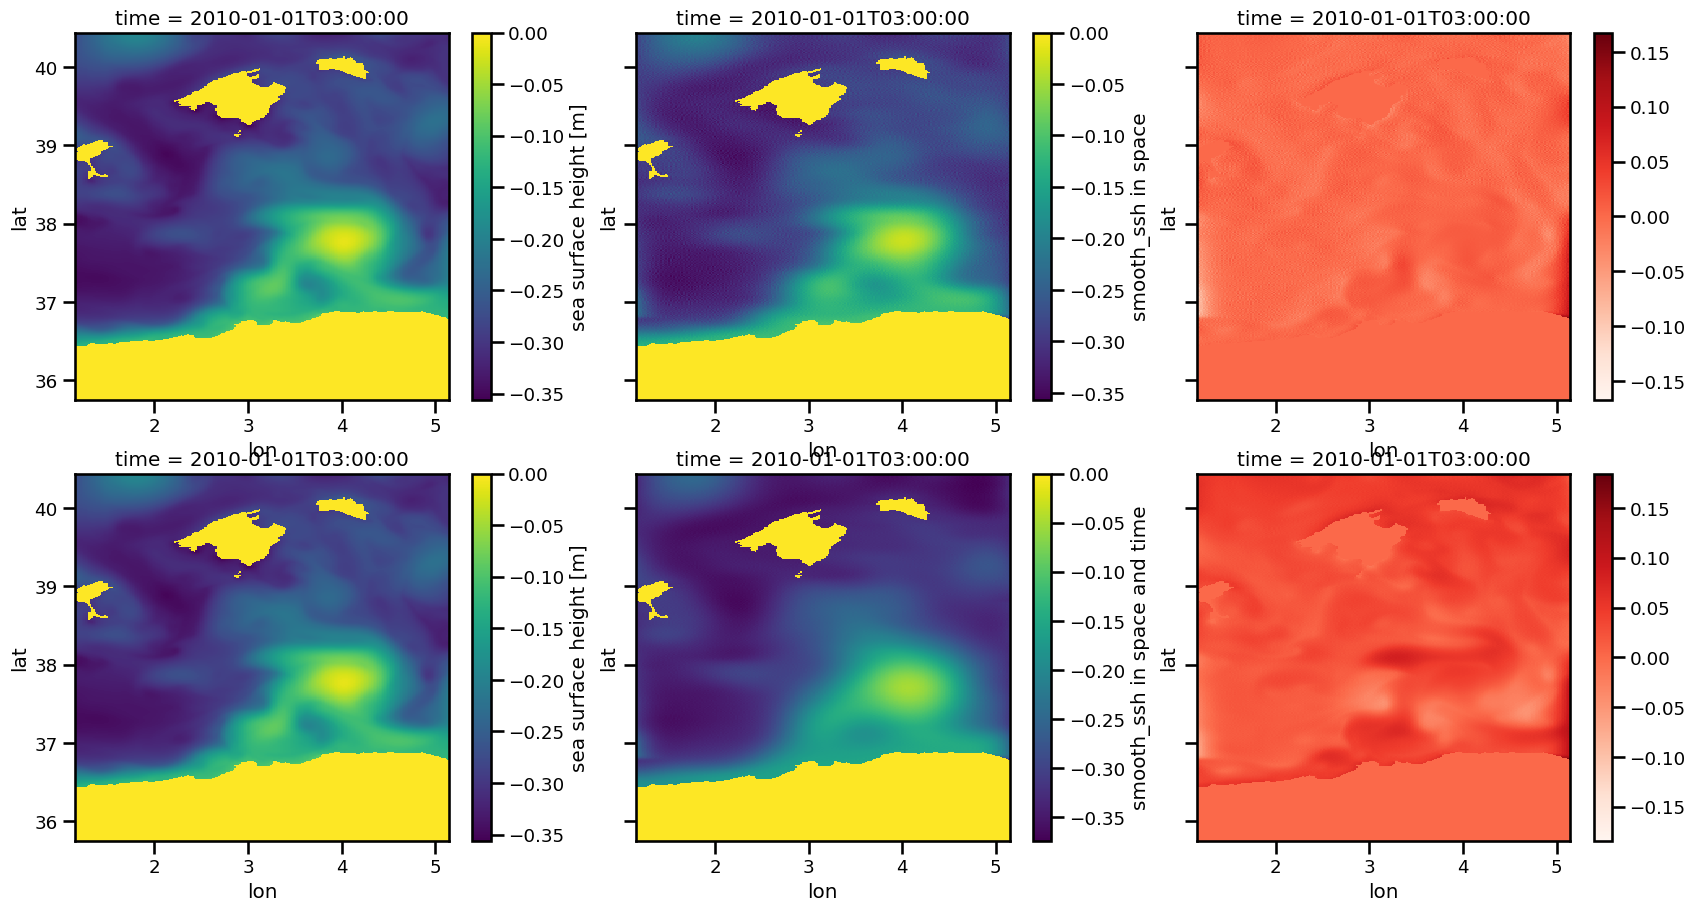

In [145]:
plt.rcParams["figure.figsize"] = [20.50, 10.50]
f, ax = plt.subplots(2, 3, sharey=True)

eNATL[vari][0,:,:].plot(ax=ax[0,0],x='lon', y='lat')
eNATL[varis][0,:,:].plot(ax=ax[0,1],x='lon', y='lat')
difff=eNATL[vari]-eNATL[varis]
difff[0,:,:].plot(ax=ax[0,2],x='lon', y='lat',cmap=cm.Reds)
eNATL[vari][0,:,:].plot(ax=ax[1,0],x='lon', y='lat')
eNATL[variss][0,:,:].plot(ax=ax[1,1],x='lon', y='lat')
difff=eNATL[vari]-eNATL[variss]
difff[0,:,:].plot(ax=ax[1,2],x='lon', y='lat',cmap=cm.Reds)

plt.show()

eNATL[vari] = eNATL[vari].fillna(0)
eNATL[varis] = eNATL[varis].fillna(0)
eNATL[variss] = eNATL[variss].fillna(0)

### Load and display   SEALEVEL_EUR_PHY_L4_MY_008_068


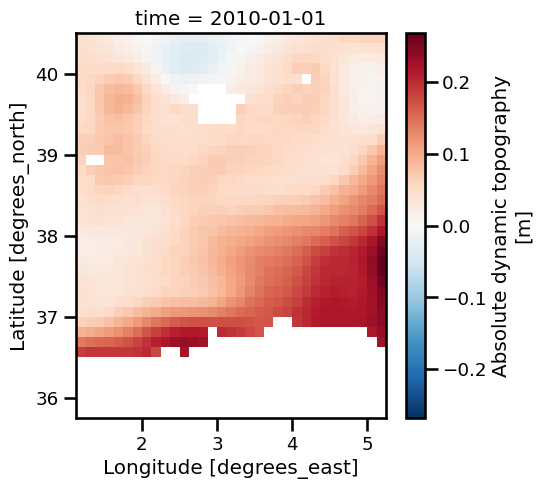

In [146]:
from mpsd import *
from myfuncts2  import *

L4 = xr.open_mfdataset('data/SSHL4.nc')

filter25km =create_filter(10000)

ssh="adt"

plt.rcParams["figure.figsize"] = [5, 5]
f, ax = plt.subplots(1, 1, sharey=True)
L4=L4.rename({'longitude': 'lon','latitude': 'lat'})

L4[ssh][0,:,:].plot(ax=ax,x='lon', y='lat')
plt.show()
L4[ssh] = L4[ssh].fillna(0)


### Computer PSD in space and time

In [147]:
signal_L4= L4[ssh].chunk({"lat":1, 'time': L4['time'].size, 'lon': L4['lon'].size})
signal_L4['time'] = (signal_L4.time - signal_L4.time[0]) / numpy.timedelta64(1, 'D')
psd_signal_L4 = xrft.power_spectrum(signal_L4, dim=['time','lon'], detrend='constant', window=True).compute()
mean_psd_signal_L4 = psd_signal_L4.mean(dim=['lat']).where( (psd_signal_L4.freq_time > 0) &(psd_signal_L4.freq_lon > 0), drop=True)

signal_eNATL= eNATL[vari].chunk({"lat":1, 'time': eNATL['time'].size, 'lon': eNATL['lon'].size})
signal_eNATL['time'] = (signal_eNATL.time - signal_eNATL.time[0]) / numpy.timedelta64(1, 'D')
psd_signal_eNATL = xrft.power_spectrum(signal_eNATL, dim=['time','lon'], detrend='constant', window=True).compute()
mean_psd_signal_eNATL = psd_signal_eNATL.mean(dim=['lat']).where( (psd_signal_eNATL.freq_time > 0)&(psd_signal_eNATL.freq_lon > 0), drop=True)


signal_seNATL= eNATL[variss].chunk({"lat":1, 'time': eNATL['time'].size, 'lon': eNATL['lon'].size})
signal_seNATL['time'] = (signal_seNATL.time - signal_seNATL.time[0]) / numpy.timedelta64(1, 'D')
psd_signal_seNATL = xrft.power_spectrum(signal_seNATL, dim=['time','lon'], detrend='constant', window=True).compute()
mean_psd_signal_seNATL = psd_signal_seNATL.mean(dim=['lat']).where( (psd_signal_seNATL.freq_time > 0)&(psd_signal_seNATL.freq_lon > 0), drop=True)

mean_psd_signal_eNATL_lon = mean_psd_signal_eNATL.mean("freq_time")
mean_psd_signal_seNATL_lon = mean_psd_signal_seNATL.mean("freq_time")
mean_psd_signal_L4_lon = mean_psd_signal_L4.mean("freq_time")

mean_psd_signal_eNATL_time = mean_psd_signal_eNATL.mean("freq_lon")
mean_psd_signal_seNATL_time = mean_psd_signal_seNATL.mean("freq_lon")
mean_psd_signal_L4_time = mean_psd_signal_L4.mean("freq_lon")

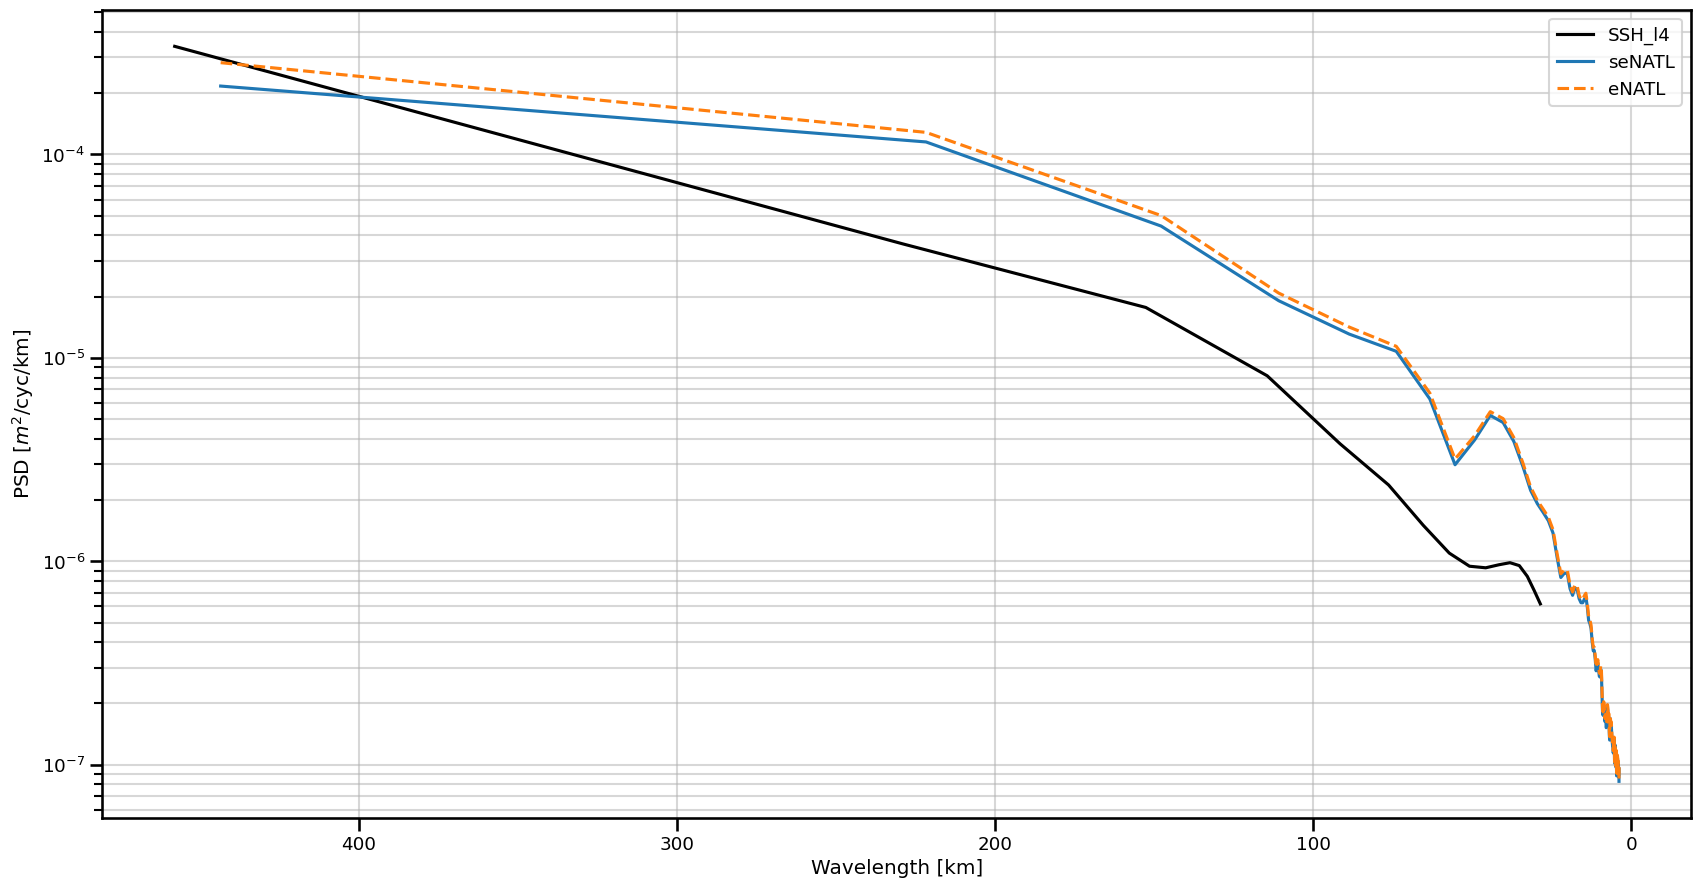

In [148]:
plt.rcParams["figure.figsize"] = [20.50, 10.50]

f, (ax1) = plt.subplots(1, 1, sharey=True)
ax1.invert_xaxis()
ax1.plot(1/mean_psd_signal_L4_lon.freq_lon*111,mean_psd_signal_L4_lon, 'k', label='SSH_l4')
ax1.plot(1/mean_psd_signal_seNATL_lon.freq_lon*111,mean_psd_signal_seNATL_lon,label='seNATL')
ax1.plot(1/mean_psd_signal_eNATL_lon.freq_lon*111,mean_psd_signal_eNATL_lon,'--',label='eNATL')
ax1.set_ylabel('PSD [$m^2$/cyc/km]')
ax1.set_xlabel('Wavelength [km]')
ax1.grid(which="both", alpha=0.5)  
ax1.legend()
ax1.set_yscale('log')
plt.show()    

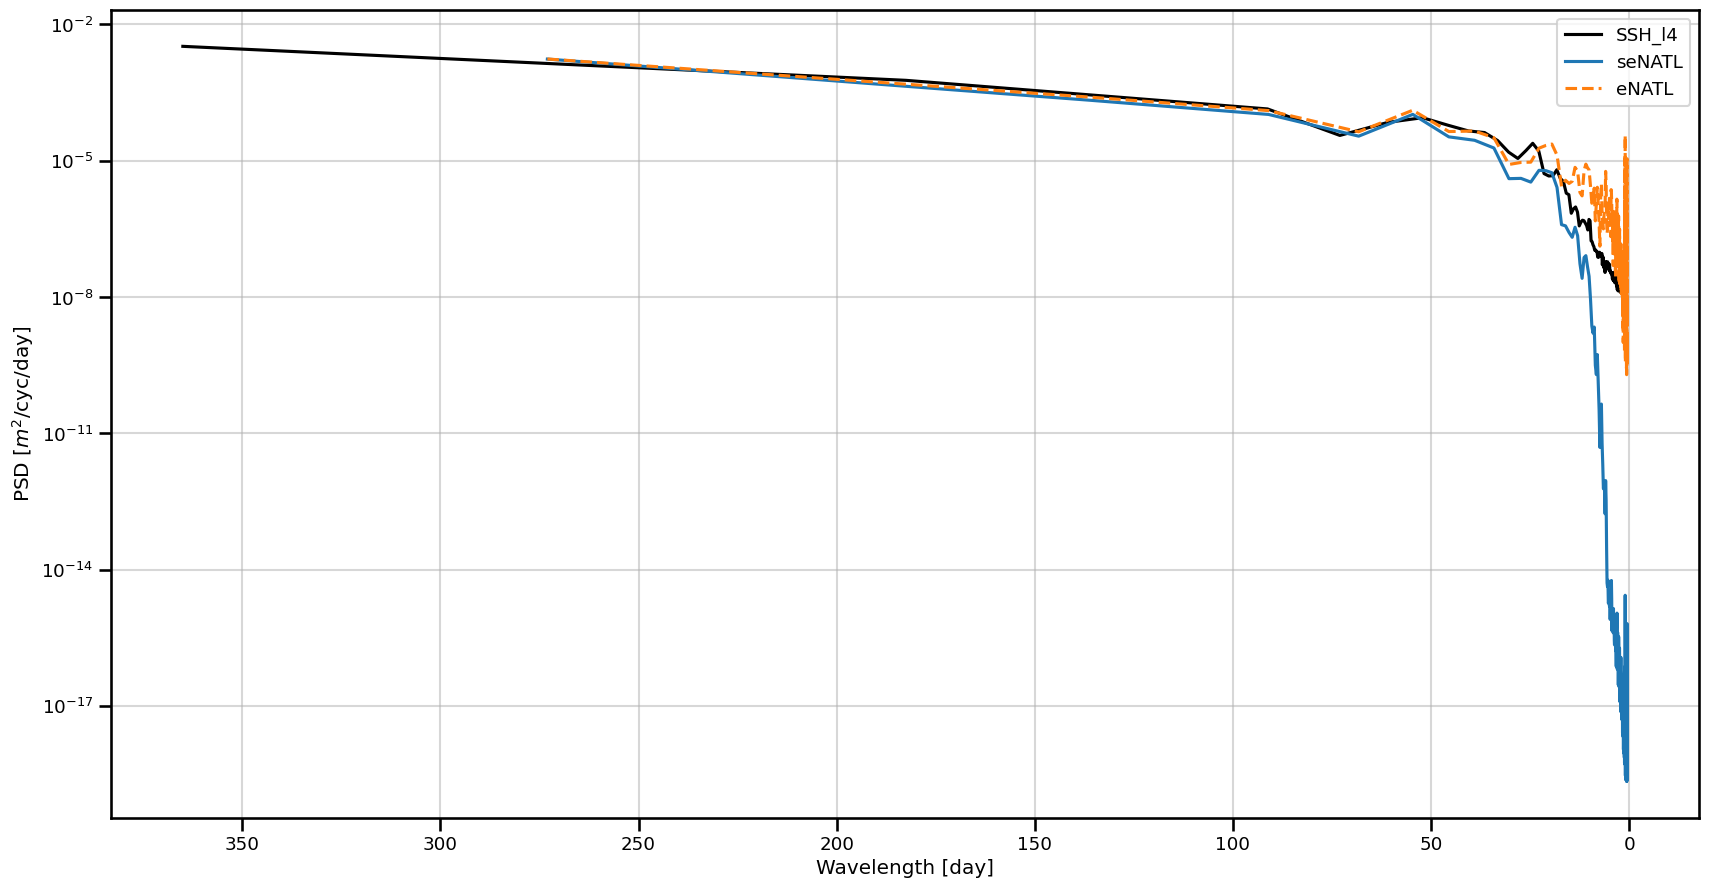

In [149]:
plt.rcParams["figure.figsize"] = [20.50, 10.50]

f, (ax1) = plt.subplots(1, 1, sharey=True)
ax1.invert_xaxis()
ax1.plot(1/mean_psd_signal_L4_time.freq_time,mean_psd_signal_L4_time, 'k', label='SSH_l4')
ax1.plot(1/mean_psd_signal_seNATL_time.freq_time,mean_psd_signal_seNATL_time,label='seNATL')
ax1.plot(1/mean_psd_signal_eNATL_time.freq_time,mean_psd_signal_eNATL_time,'--',label='eNATL')
ax1.set_ylabel('PSD [$m^2$/cyc/day]')
ax1.set_xlabel('Wavelength [day]')
ax1.grid(which="both", alpha=0.5)  
ax1.legend()
ax1.set_yscale('log')
#ax1.set_xlim(['0', '0'])
#ax1.set_ylim(['0','0.00001'])
plt.show()    

In [151]:
cs = plt.contour(1./mean_psd_signal_eNATL.freq_lon.values,1./mean_psd_signal_eNATL.freq_time.values, mean_psd_signal_eNATL, 0.5)
x05, y05 = cs.collections[0].get_paths()[0].vertices.T

print('eNATL  --->   min_space: ',numpy.min(x05), ' min_time: ',numpy.min(y05))

cs = plt.contour(1./mean_psd_signal_seNATL.freq_lon.values,1./mean_psd_signal_seNATL.freq_time.values, mean_psd_signal_seNATL, 0.5)
x05, y05 = cs.collections[0].get_paths()[0].vertices.T

print('seNATL --->   min_space: ',numpy.min(x05), ' min_time: ',numpy.min(y05))

cs = plt.contour(1./mean_psd_signal_L4.freq_lon.values,1./mean_psd_signal_L4.freq_time.values, mean_psd_signal_L4, 0.5)
x05, y05 = cs.collections[0].get_paths()[0].vertices.T

print('L4     --->   min_space: ',numpy.min(x05), ' min_time: ',numpy.min(y05))



eNATL  --->   min_space:  0.03504193456549371  min_time:  0.6176470588235294
seNATL --->   min_space:  0.11096612612406341  min_time:  0.5481927710843374
L4     --->   min_space:  0.29464285714285715  min_time:  2.1987951807228914
